### 1. データの読み込み


In [ ]:
# install.packages("MatrixExtra", "recommenderlab")
library(cmfrec)
library(Matrix)
library(MatrixExtra)
library(recommenderlab)
library(cmfrec)
library(ggplot2)

SEED < -123


In [ ]:
#' Load CAS dataset
#' 
#' @param cas_dataset_path path to CAS dataset
#' @return brvehins
load_bravehins = function(cas_dataset_path) {
  # ! git clone https://github.com/dutangc/CASdatasets.git
  load(paste(cas_dataset_path, "brvehins1a.rda", sep="/"))
  load(paste(cas_dataset_path, "brvehins1b.rda", sep="/"))
  load(paste(cas_dataset_path, "brvehins1c.rda", sep="/"))
  load(paste(cas_dataset_path, "brvehins1d.rda", sep="/"))
  load(paste(cas_dataset_path, "brvehins1e.rda", sep="/"))
  brvehins = rbind(brvehins1a, brvehins1b, brvehins1c, brvehins1d, brvehins1e)
  return(brvehins)
}

#' Subsample a COO matrix
#'
#' @param X The input COO matrix.
#' @param indices The indices of the elements to keep.
#' @return The subsampled COO matrix.
subsample_coo_matrix <- function(X, indices) {
    X@i <- X@i[indices]
    X@j <- X@j[indices]
    X@x <- X@x[indices]
    return(X)
}

#' Print the RMSE
#'
#' @param pred The predicted values.
#' @param act The actual values.
#' @return The RMSE.
print_rmse <- function(pred, act) {
  rmse <- sqrt(mean( (pred - act)^2 ))
  cat(sprintf("RMSE : %.4f\n", rmse))
  return(rmse)
}

#' Train and test split
#'
#' @param X The input COO matrix.
#' @param seed The seed for the random number generator.
#' @param ratio The ratio of the training set. Defaults to 0.75.
train_test_split <- function(X, seed=SEED, ratio=0.75) {
  set.seed(seed)
  n_ratings <- length(X@x)
  ix_train <- sample(n_ratings, floor(ratio * n_ratings), replace=FALSE)
  X_train <- subsample_coo_matrix(X, ix_train)
  X_test <- subsample_coo_matrix(X, -ix_train)  
  return(list(X_train=X_train, X_test=X_test))
}

#' Fill values lower than a threshold with NA
#'
#' @param df The input dataframe.
#' @param threshold The threshold.
#' @return The dataframe with values lower than the threshold converted to NA.
fill_with_na <- function(df, threshold) {
  df[df < threshold] <- NA
  return(df)
}

#' Get total of aggregate_col by category_to_analyze
#'
#' @param data The input data.
#' @param category_to_analyze The category to analyze.
#' @param aggregate_col The column to aggregate.
get_total = function(data, category_to_analyze, aggregate_col, threshold=NA) {
  message("aggregate_col: ", aggregate_col, "   group_cols: ", category_to_analyze)
  total_data = tapply(data[, aggregate_col], list(data[, category_to_analyze[1]],data[, category_to_analyze[2]]), sum)
  if (!is.na(threshold))
      total_data = fill_with_na(total_data, threshold)
  print(dim(total_data))
  return(total_data)
}




In [ ]:
brvehins = load_bravehins(cas_dataset_path="/Users/nanakato/projects/CASdatasets/data")
# > colnames(brvehins)
#  [1] "Gender"              "DrivAge"             "VehYear"         "VehModel"            "VehGroup"            "Area"
#  [7] "State"               "StateAb"             "ExposTotal"
# [10] "ExposFireRob"        "PremTotal"           "PremFireRob"
# [13] "SumInsAvg"           "ClaimNbRob"          "ClaimNbPartColl"
# [16] "ClaimNbTotColl"      "ClaimNbFire"         "ClaimNbOther"
# [19] "ClaimAmountRob"      "ClaimAmountPartColl" "ClaimAmountTotColl"
# [22] "ClaimAmountFire"     "ClaimAmountOther"


In [ ]:
category_to_analyze = c("Gender", "DrivAge")
# category_to_analyze = c("VehModel", "Area")
claim_types = c("ClaimAmountRob", "ClaimAmountPartColl", "ClaimAmountTotColl", "ClaimAmountFire", "ClaimAmountOther")
brvehins[, "ClaimTotal"] = rowSums(brvehins[, claim_types])

# 型だけに注目するよりもセル自体に注目した方が良いと思った
premium_total = get_total(brvehins, category_to_analyze, "PremTotal",  200000000)
exposure_total = get_total(brvehins, category_to_analyze, "ExposTotal", 100000)
claim_total = get_total(brvehins, category_to_analyze, "ClaimTotal")

# 純率にするか損害率にするかは要相談
pure_premium = premium_total / exposure_total
loss_ratio = claim_total / premium_total

# 保険料計10000以上、クレーム総額計5000以上の型だけ残す
# premium_total = premium_total[rowSums(premium_total,na.rm=T)>=10000 & rowSums(claim_total,na.rm=T)>=5000,]
# claim_total_10000 = claim_total[rowSums(premium_total,na.rm=T)>=10000 & rowSums(claim_total,na.rm=T)>=5000,]
# exposure_total_10000 = exposure_total[rowSums(premium_total,na.rm=T)>=10000 & rowSums(claim_total,na.rm=T)>=5000,]
# claim_cost = claim_total_10000/exposure_total_10000
# claim_cost[is.na(claim_cost)] <- 0
# claim_cost[is.infinite(claim_cost)] <- 0
# write.csv(as.matrix(claim_cost), file = "claim_cost.csv")

# CMFに入れるためにCOO行列に変換
pure_premium = as.coo.matrix(pure_premium)
loss_ratio = as.coo.matrix(loss_ratio)

split = train_test_split(pure_premium)
print(as.matrix(split$X_train))
print(as.matrix(split$X_test))
# the value 0 represents missing values
          
X_train = split$X_train
X_test = split$X_test

# fill missing values with 0
X_train@x[is.na(X_train@x)] <- 0
X_test@x[is.na(X_test@x)] <- 0
print(as.matrix(X_train))
print(as.matrix(X_test))
                
num_latent_factor = 2

model_classic = CMF(
  X=X_train,
  k=num_latent_factor,
  scale_lam=TRUE,
  lambda=0.1,
  verbose=TRUE,
  niter=30,
  # weight=exposure_total_10000,
)
#   k=20,
#   nonneg=TRUE,
#   centering=TRUE)

pred = predict(cmf, X_test)
write.csv(as.matrix(pred), file = "pred2.csv")

print_rmse <- function(X_test, X_hat, model_name) {
  rmse <- sqrt(mean( (X_test@x - X_hat@x)^2 ))
  cat(sprintf("RMSE for %s is: %.4f\n", model_name, rmse))
}

pred_classic <- predict(cmf, claim_cost)
print_rmse(claim_cost, pred_classic, "classic model")


model.improved <- CMF(claim_cost, k=25, lambda=0.1, scale_lam=TRUE,
                        add_implicit_features=TRUE, w_main=0.75, w_implicit=0.25,
                        use_cg=FALSE, niter=30, verbose=FALSE)

pred_improved <- predict(model.improved, claim_cost)
print_rmse(claim_cost, pred_improved, "improved classic model")

write.csv(as.matrix(pred_improved), file = "pred_improved.csv")

# A <- cmf$matrices$A
# B <- cmf$matrices$B
# type_bias <- cmf$matrices$user_bias
# region_bias <- cmf$matrices$item_bias
# mu <- cmf$matrices$glob_mean
# print(paste("A: ", "mean:", mean(A), "max:", max(A), "min:", min(A), sep=" "))
# write.csv(as.matrix(pred_handcalc), file = "pred_handcalc.csv")

# The matrices are typically fitted by initializing them to random numbers and then iteratively updating them in a way that decreases 
# the reconstruction error with respect to the observed entries in 𝐗
# , using either gradient-based procedures (e.g. stochastic gradient descent) or the ALS (alternating least-squares) method, which optimizes one matrix at a time while leaving the other fixed, performing a few sweeps until convergence.
# This library (cmfrec) will by default use the ALS method with L2 regularization, and will use user/item biases which are model parameters (updated at each iteration) rather than being pre-estimated.



In [ ]:


pred_classic <- predict(model.classic, X_test)
print_rmse(X_test, pred_classic, "classic model")
#> RMSE for classic model is: 0.9236

# i.e. it means that the ratings are off by about one star. This is better than a non-personalized model that would always predict the same rating for each user, which can also be simulated through cmfrec:

model.baseline <- MostPopular(X_train, lambda=10, scale_lam=FALSE)
pred_baseline <- predict(model.baseline, X_test)
print_rmse(X_test, pred_baseline, "non-personalized model")
#> RMSE for non-personalized model is: 0.9460

# (Note: it’s not recommended to use scaled/dynamic regularization in a most-popular model, as it will tend to recommend items with only one user giving the maximum rating.)



In [ ]:
file_path = "/Users/nanakato/projects/act-cmfreq/death_ratio.csv"
dat = read.csv(file_path, header = TRUE, row.names = 1)
dat[dat == "#DIV/0!"] <- 0
dat = as.matrix(dat)
dat = apply(dat, 2, as.numeric)



X <- dat
X <- as.coo.matrix(dat)
# str(X)

for (i in 1:25) {
    model.classic <- CMF(
        X=X,
        k=25, # k = 25: This sets the number of latent factors (or latent dimensions) to 25.  CMF works by decomposing the original matrix X_train into two (or more) lower-dimensional matrices.  k determines the dimensionality of these latent factor matrices.  Choosing the right k is important and often involves tuning (e.g., using cross-validation).  A larger k can capture more complex relationships but also increases the risk of overfitting.
        lambda=0.1, # This sets the regularization parameter (often called lambda). Regularization is a technique used to prevent overfitting.  It adds a penalty to the loss function being minimized during matrix factorization.  This penalty discourages the model from learning overly complex or specific patterns in the training data that don't generalize well to unseen data.  lambda controls the strength of this regularization.  A higher lambda means stronger regularization.
        scale_lam=TRUE, # This likely indicates that the regularization parameter lambda should be scaled or adjusted in some way.  The exact scaling method would depend on the specific CMF function being used.  It might be scaling it relative to the size of the data or some other factor.  This is often done to make the regularization more effective.
        verbose=TRUE,
    )

    pred = predict(model.classic, X)
    print_rmse(X, pred, "classic model")
}

write.csv(as.matrix(pred), file = "pred.csv")

# Improving the classical model

# By default, ALS-based models are broken down to small problems involving linear systems, which are in turned solved through the Conjugate Gradient method, but cmfrec can also use a Cholesky solver for them, which is slower but tends to result in better-quality solutions for explicit-feedback.
# As well, the default number of iterations is 10, but can be increased for better models at the expense of longer fitting times.
# But more importantly, cmfrec offers the option of adding “implicit-features” or co-factoring, which will additionally factorize binarized versions of 𝐗
#  (telling whether each entry is missing or not), sharing the same latent components with the factorization of 𝐗
#  - that is:

model.improved <- CMF(X, k=25, lambda=0.1, scale_lam=TRUE,
                      add_implicit_features=TRUE, w_main=0.75, w_implicit=0.25,
                      use_cg=FALSE, niter=30, verbose=FALSE)
pred_improved <- predict(model.improved, X)
print_rmse(X, pred_improved, "improved classic model")

write.csv(as.matrix(pred_improved), file = "pred_improved.csv")



subsample_coo_matrix <- function(X, indices) {
    X@i <- X@i[indices]
    X@j <- X@j[indices]
    X@x <- X@x[indices]
    return(X)
}

n_ratings <- length(X@x)
set.seed(123)

ix_train <- sample(n_ratings, floor(0.75 * n_ratings), replace=FALSE)
X_train <- subsample_coo_matrix(X, ix_train)
X_test <- subsample_coo_matrix(X, -ix_train)


print_rmse <- function(X_test, X_hat, model_name) {
  rmse <- sqrt(mean( (X_test@x - X_hat@x)^2 ))
  cat(sprintf("RMSE for %s is: %.4f\n", model_name, rmse))
}

pred_classic <- predict(model.classic, X_test)
print_rmse(X_test, pred_classic, "classic model")


In [62]:
library(cmfrec)

# Sample Data (replace with your actual data)
# This example uses a user-item rating matrix.
# Rows are users, columns are items, and values are ratings (e.g., 1-5).
# Missing values represent unrated items.

# Create a sparse matrix (recommended for efficiency with large datasets)
# The Matrix package is used for this
# if(!require(Matrix)){install.packages("Matrix")}
library(Matrix)

# Example rating matrix (replace with your data)
ratings_matrix <- matrix(sample(0:5, 20, replace = TRUE), nrow = 5, ncol = 4)
ratings_matrix[sample(1:20, 5)] <- NA # Introduce some missing values

sparse_ratings <- as(ratings_matrix, "sparseMatrix")

# --- Example with User and Item Features ---

# Sample User Features (replace with your actual data)
user_features <- matrix(rnorm(15), nrow = 5, ncol = 3)


# Sample Item Features (replace with your actual data)
item_features <- matrix(rnorm(12), nrow = 4, ncol = 3)

# Fit the CMF model with features
cmf_model <- CMF(
  x = sparse_ratings,
  n_factors = 2, # Number of latent factors
  user_data = user_features, # User features
  item_data = item_features, # Item features
  verbose = TRUE # Show training progress
)

# tutorial
# https://cran.r-project.org/web/packages/cmfrec/vignettes/cmfrec_vignette.html





## 2. データの前処理


In [ ]:
# test life table
# expos = read.table("https://www.ipss.go.jp/p-toukei/JMD/00/STATS/Exposures_1x1.txt",header=T,skip=2) # 生存延べ年数データの読み込み
# death = read.table("https://www.ipss.go.jp/p-toukei/JMD/00/STATS/Deaths_1x1.txt",header=T,skip=2)    # 死亡数データの読み込み

# expos = expos[expos$Age!="110+",]
# death = death[death$Age!="110+",]
# death$Year = factor(death$Year)
# death$Age = paste("000",death$Age,sep="")
# death$Age = substr(death$Age,nchar(death$Age)-2,nchar(death$Age))

# dat = cbind(death,expos[,3:5])
# colnames(dat)[6:8] = paste(colnames(dat)[6:8],".expos",sep="")
# > colnames(dat)
# [1] "Year"         "Age"          "Female"       "Male"         "Total"
# [6] "Female.expos" "Male.expos"   "Total.expos"
# write.csv(dat, file="life_table.csv", row.names=FALSE)

# death_ratio_path = "/Users/nanakato/projects/act-cmfreq/death_ratio.csv"
# dat = read.csv(death_ratio_path, header=TRUE, row.names=1)
# print(dim(dat))
# print(colnames(dat))
# print(head(dat))
# print(row.names(dat))


# loss_ratio = dat
# print(dim(loss_ratio))
# # [1]  76 110

# cmf = CMF(
#   X=loss_ratio,
#   k=1,
#   nonneg=TRUE,
#   weight=1,
# #   lambda=1000000,
# )

# A = cmf$matrices$A
# # dim(A) # [1]  1 76
# B = cmf$matrices$B
# # > dim(B)
# # [1]  1 76
# type_bias = cmf$matrices$user_bias
# > length(type_bias)
# [1] 76

# number of years
# > row.names(loss_ratio)
#  [1] "1947" "1948" "1949" "1950" "1951" "1952" "1953" "1954" "1955" "1956"
# [11] "1957" "1958" "1959" "1960" "1961" "1962" "1963" "1964" "1965" "1966"
# [21] "1967" "1968" "1969" "1970" "1971" "1972" "1973" "1974" "1975" "1976"
# [31] "1977" "1978" "1979" "1980" "1981" "1982" "1983" "1984" "1985" "1986"
# [41] "1987" "1988" "1989" "1990" "1991" "1992" "1993" "1994" "1995" "1996"
# [51] "1997" "1998" "1999" "2000" "2001" "2002" "2003" "2004" "2005" "2006"
# [61] "2007" "2008" "2009" "2010" "2011" "2012" "2013" "2014" "2015" "2016"
# [71] "2017" "2018" "2019" "2020" "2021" "2022"
# > length(row.names(loss_ratio))
# [1] 76

# region_bias = cmf$matrices$item_bias
# # > length(region_bias)
# # [1] 76

# mu = cmf$matrices$glob_mean

# # 型・地域毎の損害率の予測値
# pred_loss_ratio = mu + type_bias%o%rep(1, ncol(loss_ratio)) + rep(1,nrow(loss_ratio))%o%region_bias + t(A)%*%B




In [64]:
premium_total_10000[is.na(premium_total_10000)] = 0 # added
claim_total_10000[is.na(claim_total_10000)] = 0 # added


loss_ratio = claim_total_10000 / premium_total_10000 # 型・地域毎の損害率
loss_ratio[premium_total_10000==0] = NA # added

## 3. モデルの構築


In [65]:
cmf = CMF(
  X=loss_ratio,
  k=1,
  nonneg=TRUE,
  weight=premium_total_10000,
  lambda=1000000,
)

Warning message in validate.inputs(model = "CMF", X = X, U = U, I = I, U_bin = U_bin, :
“Attempting to use more than 1 thread, but package was compiled without OpenMP support. See https://github.com/david-cortes/installing-optimized-libraries#4-macos-install-and-enable-openmp”
Warning message in validate.inputs(model = "CMF", X = X, U = U, I = I, U_bin = U_bin, :
“Warning: fitting a model with centering and non-negativity constraints.”


Starting ALS optimization routine

Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully


## 4. 推定値と実績値の比較


In [66]:
A = cmf$matrices$A
B = cmf$matrices$B
type_bias = cmf$matrices$user_bias
region_bias = cmf$matrices$item_bias
mu = cmf$matrices$glob_mean

# 型・地域毎の損害率の予測値
pred_loss_ratio = mu + type_bias%o%rep(1, ncol(loss_ratio)) + rep(1,nrow(loss_ratio))%o%region_bias + t(A)%*%B

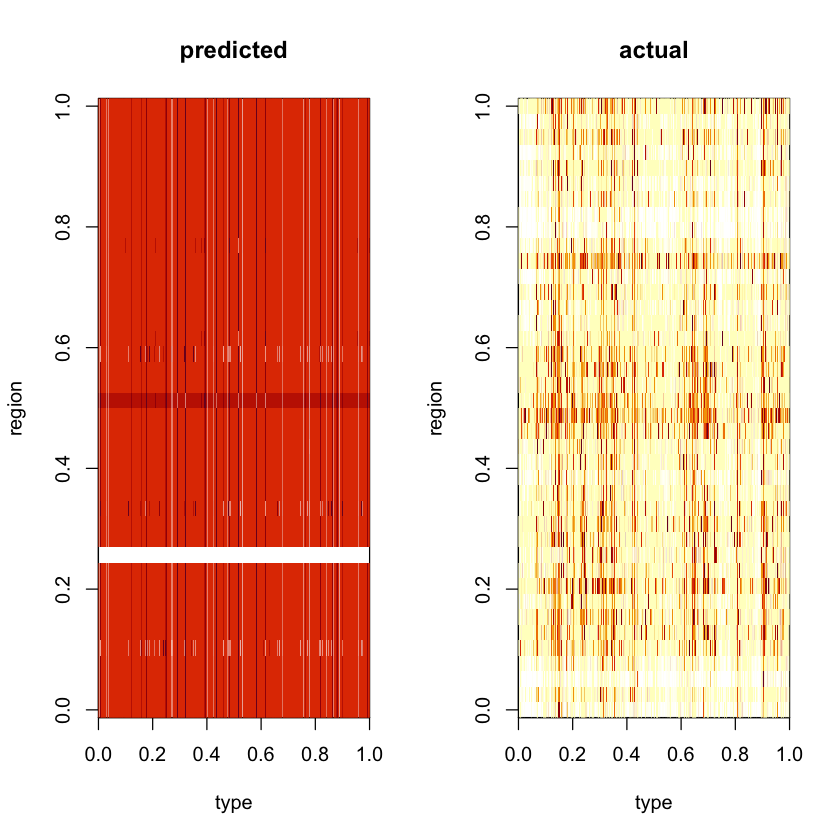

In [67]:
# ヒートマップ
par(mfrow=c(1, 2))
image(pred_loss_ratio, xlab="type", ylab="region", breaks=0:12/10, main="predicted")
image(loss_ratio, xlab="type",ylab="region",breaks=0:12/10, main="actual")


Warning message:
“Removed 27740 rows containing missing values (`geom_point()`).”


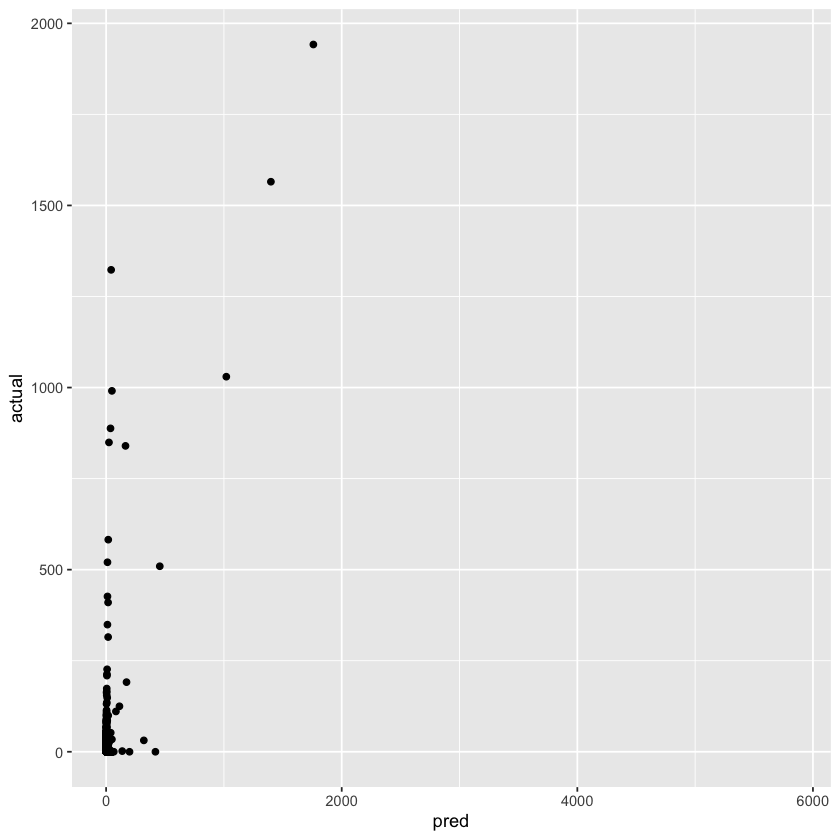

In [68]:
# 散布図
compare = data.frame(
  pred = as.vector(pred_loss_ratio),
  actual = as.vector(loss_ratio)
)
max_value = max(compare$pred, compare$actual)
min_value = min(compare$pred, compare$actual)
ggplot(compare,aes(x=pred,y=actual)) + geom_point() + xlim(min_value,max_value) + ylim(min_value,max_value)